Kuo Yang, Lab 6, 11/16/25  
CS 121/Python DSML  
East Los Angeles College, FA 2025

***
Same as Lab5, but with seaborn plots  
Changes:
1) more time-series plots
2) box+violin plots of ages

***

Executive Summary:
1) There is a rapid increase of events, both serious and non-serious, starting in 2020 and accelerated in 2023. This increase is driven entirely by tirzepatide and semaglutide.
2) The age of serious events of women on compounded liraglutide/semaglutide/tirzepatide is particularly young, avg at mid-late 40s (popln mean=58)

In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1: Creating and exploring pandas data series

In [236]:
glp1=pd.read_csv('glp1df.csv') #not sure why, but if I include encoding='latin1' I lose some data in api1 column
print(glp1.shape)

(300554, 25)


In [237]:
glp1.head()

,Case ID,Suspect Product Names,Suspect Product Active Ingredients,Reason for Use,Reactions,Serious,Outcomes,Sex,Event Date,Latest FDA Received Date,...,Report Source,Concomitant Product Names,Latest Manufacturer Received Date,Initial FDA Received Date,Country where Event occurred,Reported to Manufacturer?,Manufacturer Control Number,Literature Reference,Compounded Flag,api1
0,25142581,Trulicity,Dulaglutide,Product Used For Unknown Indication,Injection Site Pain,Non-Serious,Non-Serious,Male,-,31-MAR-2025,...,Not Specified,-,24-MAR-2025,31-MAR-2025,US,Not Specified,US-ELI_LILLY_AND_COMPANY-US202503021448,-,-,1
1,25142580,Trulicity,Dulaglutide,Type 2 Diabetes Mellitus,Visual Impairment;Product Storage Error,Non-Serious,Non-Serious,Female,-,31-MAR-2025,...,Not Specified,-,24-MAR-2025,31-MAR-2025,US,Not Specified,US-ELI_LILLY_AND_COMPANY-US202503021444,-,-,1
2,25141349,Trulicity,Dulaglutide,Product Used For Unknown Indication,Inappropriate Schedule Of Product Administrati...,Non-Serious,Non-Serious,Male,25-MAR-2025,31-MAR-2025,...,Not Specified,-,28-MAR-2025,31-MAR-2025,US,Not Specified,US-ELI_LILLY_AND_COMPANY-US202503025775,-,-,1
3,25140677,Trulicity,Dulaglutide,Type 2 Diabetes Mellitus,Depression;Decreased Appetite;Schizophrenia;Ma...,Serious,Hospitalized,Female,DEC-2024,31-MAR-2025,...,Not Specified,-,25-MAR-2025,31-MAR-2025,JP,Not Specified,JP-ELI_LILLY_AND_COMPANY-JP202503002636,-,-,1
4,25140673,Trulicity,Dulaglutide,Product Used For Unknown Indication,Paraesthesia,Non-Serious,Non-Serious,Female,-,31-MAR-2025,...,Not Specified,-,27-MAR-2025,31-MAR-2025,US,Not Specified,US-ELI_LILLY_AND_COMPANY-US202503024471,-,-,1


In [238]:
glp1.columns

Index(['Case ID', 'Suspect Product Names',
       'Suspect Product Active Ingredients', 'Reason for Use', 'Reactions',
       'Serious', 'Outcomes', 'Sex', 'Event Date', 'Latest FDA Received Date',
       'Case Priority', 'Patient Age', 'Patient Weight', 'Sender',
       'Reporter Type', 'Report Source', 'Concomitant Product Names',
       'Latest Manufacturer Received Date', 'Initial FDA Received Date',
       'Country where Event occurred', 'Reported to Manufacturer?',
       'Manufacturer Control Number', 'Literature Reference',
       'Compounded Flag', 'api1'],
      dtype='object')

### <span style="color:red;">Standardizing Year. (Courtesy of Ramirez,J of ELAC) </span>


In [239]:

UNIT_MAP = {
    'yr': 'year', 'yrs': 'year', 'y': 'year', 'year': 'year', 'years': 'year',
    'day': 'day', 'days': 'day', 'd': 'day',
    'week': 'week', 'weeks': 'week', 'wk': 'week', 'wks': 'week',
    'mth': 'month', 'mon': 'month', 'month': 'month', 'months': 'month', 'mo': 'month',
    'dec': 'decade', 'decade': 'decade', 'decades': 'decade'
}

In [240]:
import re

def parse_age_to_years(val):
    # handle missing/unknown
    if pd.isna(val):
        return np.nan
    s = str(val).strip().lower()
    if s in ('', 'nan', 'none', 'not specified', 'unknown'):
        return np.nan

    # grab first number (allow decimals)
    mnum = re.search(r'(\d+(\.\d+)?)', s)
    if not mnum:
        return np.nan
    num = float(mnum.group(1))

    # find a recognizable unit token, prefer the last token in the string
    toks = re.findall(r'[a-z]+', s)
    unit_std = None
    for tok in reversed(toks):
        if tok in UNIT_MAP:
            unit_std = UNIT_MAP[tok]
            break

    # convert to years
    if unit_std in (None, 'year'):
        years = num
    elif unit_std == 'month':
        years = num / 12.0
    elif unit_std == 'week':
        years = num / 52.0
    elif unit_std == 'day':
        years = num / 365.0
    elif unit_std == 'decade':
        years = num * 10.0
    else:
        years = np.nan

    return years

### <span style="color:red;">Age_Years (Courtesy of Ramirez,J, ELAC) </span>


In [241]:
glp1['Age_Years'] = glp1['Patient Age'].apply(parse_age_to_years)
print(glp1[['Patient Age', 'Age_Years']])


       Patient Age  Age_Years
0            80 YR       80.0
1            80 YR       80.0
2            85 YR       85.0
3            71 YR       71.0
4            63 YR       63.0
...            ...        ...
300549       55 YR       55.0
300550       32 YR       32.0
300551       49 YR       49.0
300552       74 YR       74.0
300553       32 YR       32.0

[300554 rows x 2 columns]


###Compounded Data Map (new column: CMPD)

In [242]:
glp1['Compounded Flag'].unique()

array(['-', 'Yes'], dtype=object)

In [243]:
#create column cmpd, where 1=yes, 2=no (-)
glp1['CMPD'] = glp1['Compounded Flag'].map({'Yes': 1, '-': 0})

In [244]:
glp1.head()

,Case ID,Suspect Product Names,Suspect Product Active Ingredients,Reason for Use,Reactions,Serious,Outcomes,Sex,Event Date,Latest FDA Received Date,...,Latest Manufacturer Received Date,Initial FDA Received Date,Country where Event occurred,Reported to Manufacturer?,Manufacturer Control Number,Literature Reference,Compounded Flag,api1,Age_Years,CMPD
0,25142581,Trulicity,Dulaglutide,Product Used For Unknown Indication,Injection Site Pain,Non-Serious,Non-Serious,Male,-,31-MAR-2025,...,24-MAR-2025,31-MAR-2025,US,Not Specified,US-ELI_LILLY_AND_COMPANY-US202503021448,-,-,1,80.0,0
1,25142580,Trulicity,Dulaglutide,Type 2 Diabetes Mellitus,Visual Impairment;Product Storage Error,Non-Serious,Non-Serious,Female,-,31-MAR-2025,...,24-MAR-2025,31-MAR-2025,US,Not Specified,US-ELI_LILLY_AND_COMPANY-US202503021444,-,-,1,80.0,0
2,25141349,Trulicity,Dulaglutide,Product Used For Unknown Indication,Inappropriate Schedule Of Product Administrati...,Non-Serious,Non-Serious,Male,25-MAR-2025,31-MAR-2025,...,28-MAR-2025,31-MAR-2025,US,Not Specified,US-ELI_LILLY_AND_COMPANY-US202503025775,-,-,1,85.0,0
3,25140677,Trulicity,Dulaglutide,Type 2 Diabetes Mellitus,Depression;Decreased Appetite;Schizophrenia;Ma...,Serious,Hospitalized,Female,DEC-2024,31-MAR-2025,...,25-MAR-2025,31-MAR-2025,JP,Not Specified,JP-ELI_LILLY_AND_COMPANY-JP202503002636,-,-,1,71.0,0
4,25140673,Trulicity,Dulaglutide,Product Used For Unknown Indication,Paraesthesia,Non-Serious,Non-Serious,Female,-,31-MAR-2025,...,27-MAR-2025,31-MAR-2025,US,Not Specified,US-ELI_LILLY_AND_COMPANY-US202503024471,-,-,1,63.0,0


###Clean Initial FDA Date ("Year1" column)

In [245]:
glp1['Year1']=glp1['Initial FDA Received Date'].str[-4:].astype(int)

###Clean Weight Column ("Weight2")

In [246]:
glp1['Weight1']=pd.to_numeric(glp1['Patient Weight'].str.replace('[^\\d.]','',regex=True),errors='coerce')

## 2: Serious vs. Non-Serious Rxns

In [247]:
glp1_srscnt=glp1[['Case ID','Serious']]
glp1_srscnt2=glp1_srscnt.groupby('Serious',as_index=False).count()
print(glp1_srscnt)
print(glp1_srscnt2)

         Case ID      Serious
0       25142581  Non-Serious
1       25142580  Non-Serious
2       25141349  Non-Serious
3       25140677      Serious
4       25140673  Non-Serious
...          ...          ...
300549  24904201      Serious
300550  24642147      Serious
300551  24398076      Serious
300552  24327525  Non-Serious
300553  24129001      Serious

[300554 rows x 2 columns]
       Serious  Case ID
0  Non-Serious   222536
1      Serious    78018


### All Cases: Serious vs. Non-Serious

Most Reactions were nonserious reactions, though serious events made up a significant proportion at 26%

In [248]:
glp1_srscnt.head()

,Case ID,Serious
0,25142581,Non-Serious
1,25142580,Non-Serious
2,25141349,Non-Serious
3,25140677,Serious
4,25140673,Non-Serious


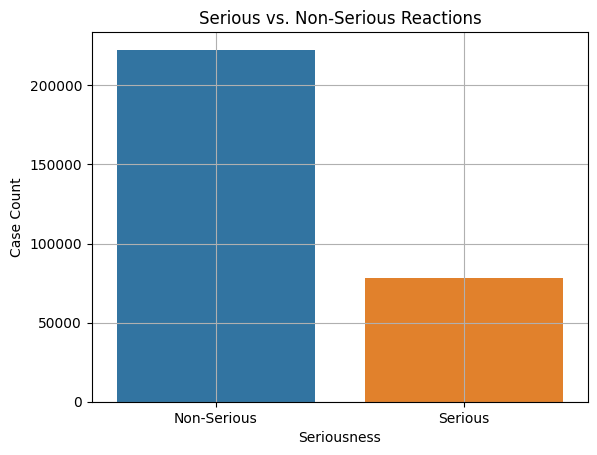

In [249]:
#seaborn bar chart 1 (serious+nonserious cases overall)
sns.countplot(x='Serious',data=glp1_srscnt,hue='Serious')
plt.grid()
plt.title('Serious vs. Non-Serious Reactions')
plt.xlabel('Seriousness')
plt.ylabel('Case Count')
plt.show()

Looking from a bar plot, Serious cases (red), though less than non-serious, are still significant.

###Time-Series of All Cases

In [250]:
glp1_time1 = glp1.groupby(['Serious','Year1'],as_index=False)['Case ID'].count()
print(glp1_time1)

        Serious  Year1  Case ID
0   Non-Serious   1984        2
1   Non-Serious   1985        1
2   Non-Serious   1999        1
3   Non-Serious   2002        5
4   Non-Serious   2003       17
5   Non-Serious   2004        4
6   Non-Serious   2005     1873
7   Non-Serious   2006    12288
8   Non-Serious   2007    11780
9   Non-Serious   2008     6189
10  Non-Serious   2009       53
11  Non-Serious   2010     2208
12  Non-Serious   2011     4262
13  Non-Serious   2012     3853
14  Non-Serious   2013     3859
15  Non-Serious   2014     3132
16  Non-Serious   2015     7179
17  Non-Serious   2016     7186
18  Non-Serious   2017     8694
19  Non-Serious   2018    10632
20  Non-Serious   2019    11144
21  Non-Serious   2020    13529
22  Non-Serious   2021    14643
23  Non-Serious   2022    18069
24  Non-Serious   2023    31438
25  Non-Serious   2024    39777
26  Non-Serious   2025    10718
27      Serious   2004        1
28      Serious   2005      183
29      Serious   2006      637
30      

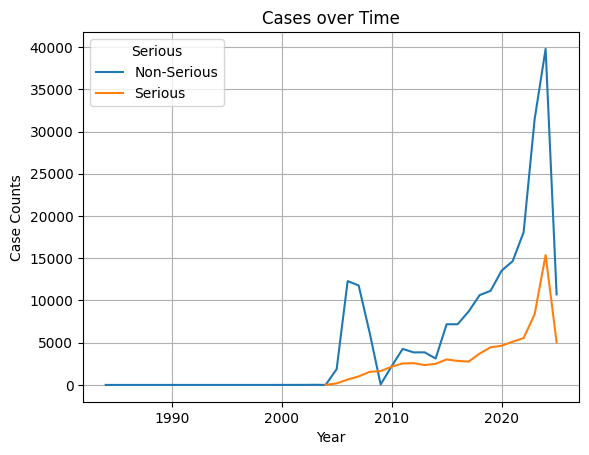

In [251]:
sns.lineplot(x='Year1',y='Case ID',data=glp1_time1,hue='Serious')
plt.grid()
plt.title('Cases over Time')
plt.xlabel('Year')
plt.ylabel('Case Counts')
plt.show()

Number of cases increased dramatically since 2020, for both serious and non-serious cases over time. Please note that the last year, 2025, contained incomplete data (hence the steep dropoff). The overall increase reflects the increased use of GLP-1s overall. I think the strange blip in around 2005 non-serious cases is an artifact, data needs to be checked.

###Age and Weight Correlation

In [252]:
#create age vs weight dataset
glp1_agewt=glp1[['Age_Years','Weight1','Serious','Sex','Year1']]
#filter in age between 0 and 150, weight <300kg
glp1_agewt2=glp1_agewt.query('Age_Years > 0 & Age_Years < 150 & Weight1 < 300')
print(glp1_agewt2)

        Age_Years  Weight1      Serious     Sex  Year1
7            44.0   79.365      Serious  Female   2025
12           89.0   86.168  Non-Serious  Female   2025
18           62.0   77.564  Non-Serious  Female   2025
49           41.0  136.050      Serious  Female   2025
50           69.0  150.000      Serious  Female   2025
...           ...      ...          ...     ...    ...
300549       55.0   67.500      Serious  Female   2025
300550       32.0   92.250      Serious  Female   2024
300551       49.0   62.550      Serious  Female   2024
300552       74.0   86.400  Non-Serious  Female   2024
300553       32.0   93.600      Serious  Female   2024

[51836 rows x 5 columns]


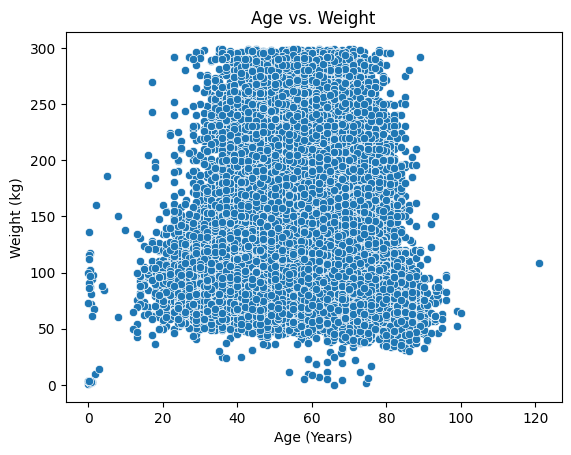

In [253]:
sns.scatterplot(x='Age_Years',y='Weight1',data=glp1_agewt2)
plt.title('Age vs. Weight')
plt.xlabel('Age (Years)')
plt.ylabel('Weight (kg)')
plt.show()

No correlation between age and weight.

## 3: Serious Events

In [254]:
#Query method for Serious, Non-Serious Reactions
glp1_s=glp1.query("Serious == 'Serious'")
glp1_ns=glp1.query("Serious == 'Non-Serious'")
print('Serious:',glp1_s.shape, '\t |non-serious: ', glp1_ns.shape)

Serious: (78018, 29) 	 |non-serious:  (222536, 29)


In [255]:
glp1_s.head()

,Case ID,Suspect Product Names,Suspect Product Active Ingredients,Reason for Use,Reactions,Serious,Outcomes,Sex,Event Date,Latest FDA Received Date,...,Country where Event occurred,Reported to Manufacturer?,Manufacturer Control Number,Literature Reference,Compounded Flag,api1,Age_Years,CMPD,Year1,Weight1
3,25140677,Trulicity,Dulaglutide,Type 2 Diabetes Mellitus,Depression;Decreased Appetite;Schizophrenia;Ma...,Serious,Hospitalized,Female,DEC-2024,31-MAR-2025,...,JP,Not Specified,JP-ELI_LILLY_AND_COMPANY-JP202503002636,-,-,1,71.0,0,2025,NaN
7,25139513,Trulicity;Ozempic,Semaglutide;Dulaglutide,Blood Cholesterol Increased;Gastrooesophageal ...,Decreased Appetite;Impaired Gastric Emptying,Serious,Other Outcomes;Hospitalized,Female,01-DEC-2022,31-MAR-2025,...,US,Not Specified,US-NOVOPROD-1319160,-,-,1,44.0,0,2025,79.365
17,25138176,Trulicity;Ozempic,Semaglutide;Dulaglutide,Product Used For Unknown Indication,Nausea;Impaired Gastric Emptying;Diarrhoea;Vom...,Serious,Other Outcomes,Not Specified,-,30-MAR-2025,...,US,Not Specified,US-ELI_LILLY_AND_COMPANY-US202503024418,-,-,1,66.0,0,2025,NaN
20,25140295,-,Dulaglutide,Diabetes Mellitus,Pancreatitis Acute,Serious,Required Intervention;Hospitalized,Male,16-OCT-2024,28-MAR-2025,...,Not Specified,Not Specified,-,-,-,1,74.0,0,2025,NaN
21,25137010,Trulicity,Dulaglutide,Product Used For Unknown Indication;Type 2 Dia...,Macular Degeneration,Serious,Other Outcomes,Male,-,28-MAR-2025,...,US,Not Specified,US-ELI_LILLY_AND_COMPANY-US202503017503,-,-,1,83.0,0,2025,NaN


In [256]:
glp1_ns.head()

,Case ID,Suspect Product Names,Suspect Product Active Ingredients,Reason for Use,Reactions,Serious,Outcomes,Sex,Event Date,Latest FDA Received Date,...,Country where Event occurred,Reported to Manufacturer?,Manufacturer Control Number,Literature Reference,Compounded Flag,api1,Age_Years,CMPD,Year1,Weight1
0,25142581,Trulicity,Dulaglutide,Product Used For Unknown Indication,Injection Site Pain,Non-Serious,Non-Serious,Male,-,31-MAR-2025,...,US,Not Specified,US-ELI_LILLY_AND_COMPANY-US202503021448,-,-,1,80.0,0,2025,NaN
1,25142580,Trulicity,Dulaglutide,Type 2 Diabetes Mellitus,Visual Impairment;Product Storage Error,Non-Serious,Non-Serious,Female,-,31-MAR-2025,...,US,Not Specified,US-ELI_LILLY_AND_COMPANY-US202503021444,-,-,1,80.0,0,2025,NaN
2,25141349,Trulicity,Dulaglutide,Product Used For Unknown Indication,Inappropriate Schedule Of Product Administrati...,Non-Serious,Non-Serious,Male,25-MAR-2025,31-MAR-2025,...,US,Not Specified,US-ELI_LILLY_AND_COMPANY-US202503025775,-,-,1,85.0,0,2025,NaN
4,25140673,Trulicity,Dulaglutide,Product Used For Unknown Indication,Paraesthesia,Non-Serious,Non-Serious,Female,-,31-MAR-2025,...,US,Not Specified,US-ELI_LILLY_AND_COMPANY-US202503024471,-,-,1,63.0,0,2025,NaN
5,25140096,Trulicity,Dulaglutide,Product Used For Unknown Indication,Injection Site Bruising;Incorrect Dose Adminis...,Non-Serious,Non-Serious,Female,MAR-2025,31-MAR-2025,...,US,Not Specified,US-ELI_LILLY_AND_COMPANY-US202503025952,-,-,1,42.0,0,2025,NaN


### Time-Series

I want to see how the serious events trend over time, split by Sex:

In [257]:
glp1_time2 = glp1_s.groupby(['Sex','Year1'],as_index=False)['Case ID'].count()
print(glp1_time2)

              Sex  Year1  Case ID
0          Female   2004        1
1          Female   2005      110
2          Female   2006      397
3          Female   2007      643
4          Female   2008      944
..            ...    ...      ...
59  Not Specified   2021      328
60  Not Specified   2022      349
61  Not Specified   2023      689
62  Not Specified   2024     1434
63  Not Specified   2025      665

[64 rows x 3 columns]


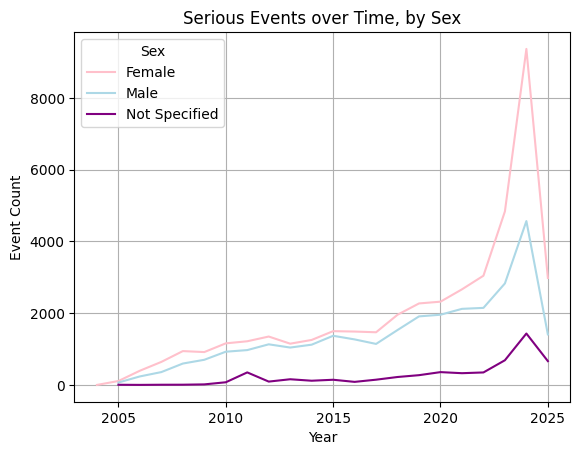

In [258]:
sns.lineplot(x='Year1',y='Case ID',data=glp1_time2,hue='Sex',
             palette=['pink','lightblue','purple'])
plt.grid()
plt.title('Serious Events over Time, by Sex')
plt.xlabel('Year')
plt.ylabel('Event Count')
plt.show()

And it looks like the increase is equally attributed between sexes, and neither F/M is driving the increase.

In [259]:
glp1_time3 = glp1_s.groupby(['api1','Year1'],as_index=False)['Case ID'].count()
print(glp1_time3)

    api1  Year1  Case ID
0      1   2012        2
1      1   2015      237
2      1   2016      799
3      1   2017     1117
4      1   2018     1438
..   ...    ...      ...
65     5   2021        5
66     5   2022      308
67     5   2023     1750
68     5   2024     4608
69     5   2025     1808

[70 rows x 3 columns]


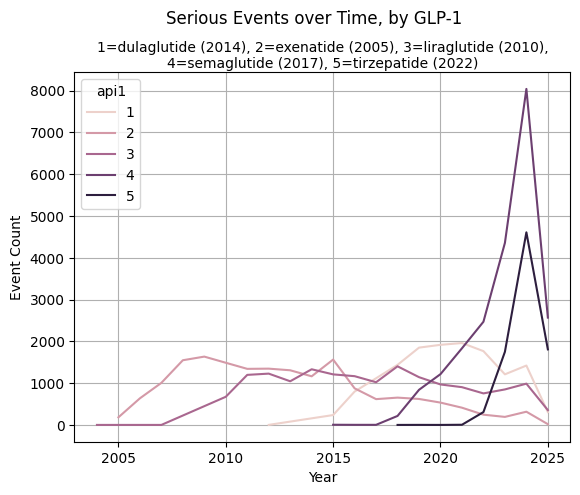

In [260]:
sns.lineplot(x='Year1',y='Case ID',data=glp1_time3,hue='api1')
plt.grid()
plt.suptitle('Serious Events over Time, by GLP-1',y=1.01)
plt.title('1=dulaglutide (2014), 2=exenatide (2005), 3=liraglutide (2010),\n4=semaglutide (2017), 5=tirzepatide (2022)',
          fontsize=10,y=0.99)
plt.xlabel('Year')
plt.ylabel('Event Count')
plt.show()

It looks like semaglutide and tirzepatide is driving most of the increase in serious events. In the analysis below, let's see if it's attributable to other factors as well.

In [261]:
glp1_time4 = glp1_s.groupby(['api1','Sex','Year1'],as_index=False)['Case ID'].count()
api1map={1:'dulaglutide',2:'exenatide',3:'liraglutide',4:'semaglutide',5:'tirzepatide'}
glp1_time4['api2']=glp1_time4['api1'].map(api1map)
print(glp1_time4)

     api1            Sex  Year1  Case ID         api2
0       1         Female   2012        1  dulaglutide
1       1         Female   2015      123  dulaglutide
2       1         Female   2016      393  dulaglutide
3       1         Female   2017      528  dulaglutide
4       1         Female   2018      725  dulaglutide
..    ...            ...    ...      ...          ...
191     5           Male   2025      409  tirzepatide
192     5  Not Specified   2022       42  tirzepatide
193     5  Not Specified   2023      311  tirzepatide
194     5  Not Specified   2024      584  tirzepatide
195     5  Not Specified   2025      288  tirzepatide

[196 rows x 5 columns]


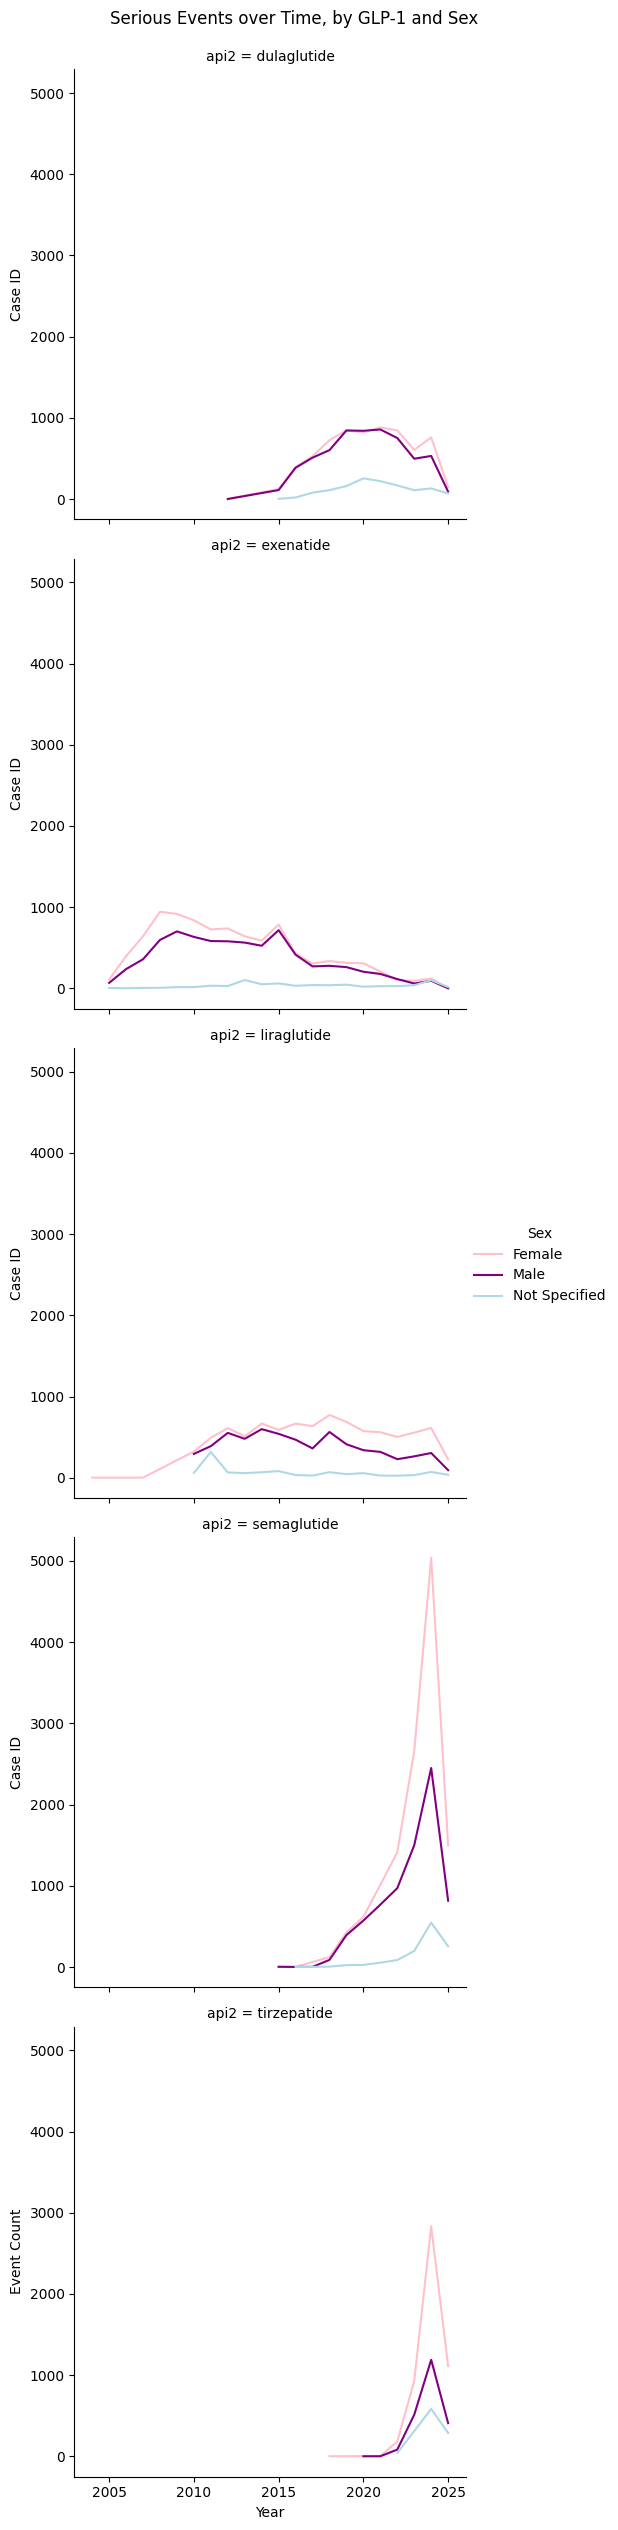

In [262]:
sns.relplot(x='Year1',y='Case ID',row='api2',data=glp1_time4,hue='Sex',
            kind='line',palette=['pink','purple','lightblue'])
plt.suptitle('Serious Events over Time, by GLP-1 and Sex',y=1.01)
plt.xlabel('Year')
plt.ylabel('Event Count')
plt.show()

In the last two plots, we can see the rapid increase from 2020 to 2024 (2025 inomplete data) that's driven by semaglutide and tirzepatide.

In [263]:
glp1_time5 = glp1_s.groupby(['CMPD','Year1'],as_index=False)['Case ID'].count()
print(glp1_time5)

    CMPD  Year1  Case ID
0      0   2004        1
1      0   2005      183
2      0   2006      637
3      0   2007     1008
4      0   2008     1548
5      0   2009     1635
6      0   2010     2162
7      0   2011     2540
8      0   2012     2577
9      0   2013     2353
10     0   2014     2496
11     0   2015     3016
12     0   2016     2844
13     0   2017     2754
14     0   2018     3701
15     0   2019     4433
16     0   2020     4609
17     0   2021     5074
18     0   2022     5480
19     0   2023     8119
20     0   2024    14995
21     0   2025     4952
22     1   2016        1
23     1   2017        6
24     1   2018       11
25     1   2019       25
26     1   2020       29
27     1   2021       42
28     1   2022       64
29     1   2023      240
30     1   2024      377
31     1   2025      106


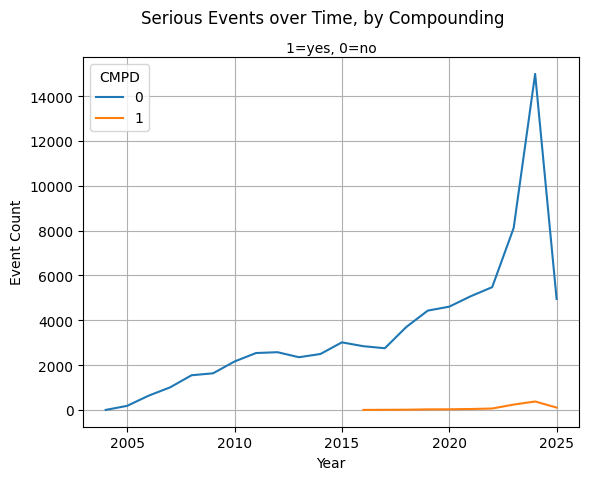

In [264]:
sns.lineplot(x='Year1',y='Case ID',data=glp1_time5,hue='CMPD')
plt.grid()
plt.suptitle('Serious Events over Time, by Compounding')
plt.title('1=yes, 0=no',fontsize=10,y=0.99)
plt.xlabel('Year')
plt.ylabel('Event Count')
plt.show()

There's an increase in both compounded and non-compounded GLP-1s, so I don't think it's attributable to this variable.

In [265]:
glp1_time6 = glp1_s.groupby(['api1','CMPD','Year1'],as_index=False)['Case ID'].count()
api1map={1:'dulaglutide',2:'exenatide',3:'liraglutide',4:'semaglutide',5:'tirzepatide'}
glp1_time6['api2']=glp1_time6['api1'].map(api1map)
print(glp1_time6)

     api1  CMPD  Year1  Case ID         api2
0       1     0   2012        2  dulaglutide
1       1     0   2015      237  dulaglutide
2       1     0   2016      799  dulaglutide
3       1     0   2017     1115  dulaglutide
4       1     0   2018     1437  dulaglutide
..    ...   ...    ...      ...          ...
100     5     0   2025     1766  tirzepatide
101     5     1   2022       10  tirzepatide
102     5     1   2023       32  tirzepatide
103     5     1   2024      119  tirzepatide
104     5     1   2025       42  tirzepatide

[105 rows x 5 columns]


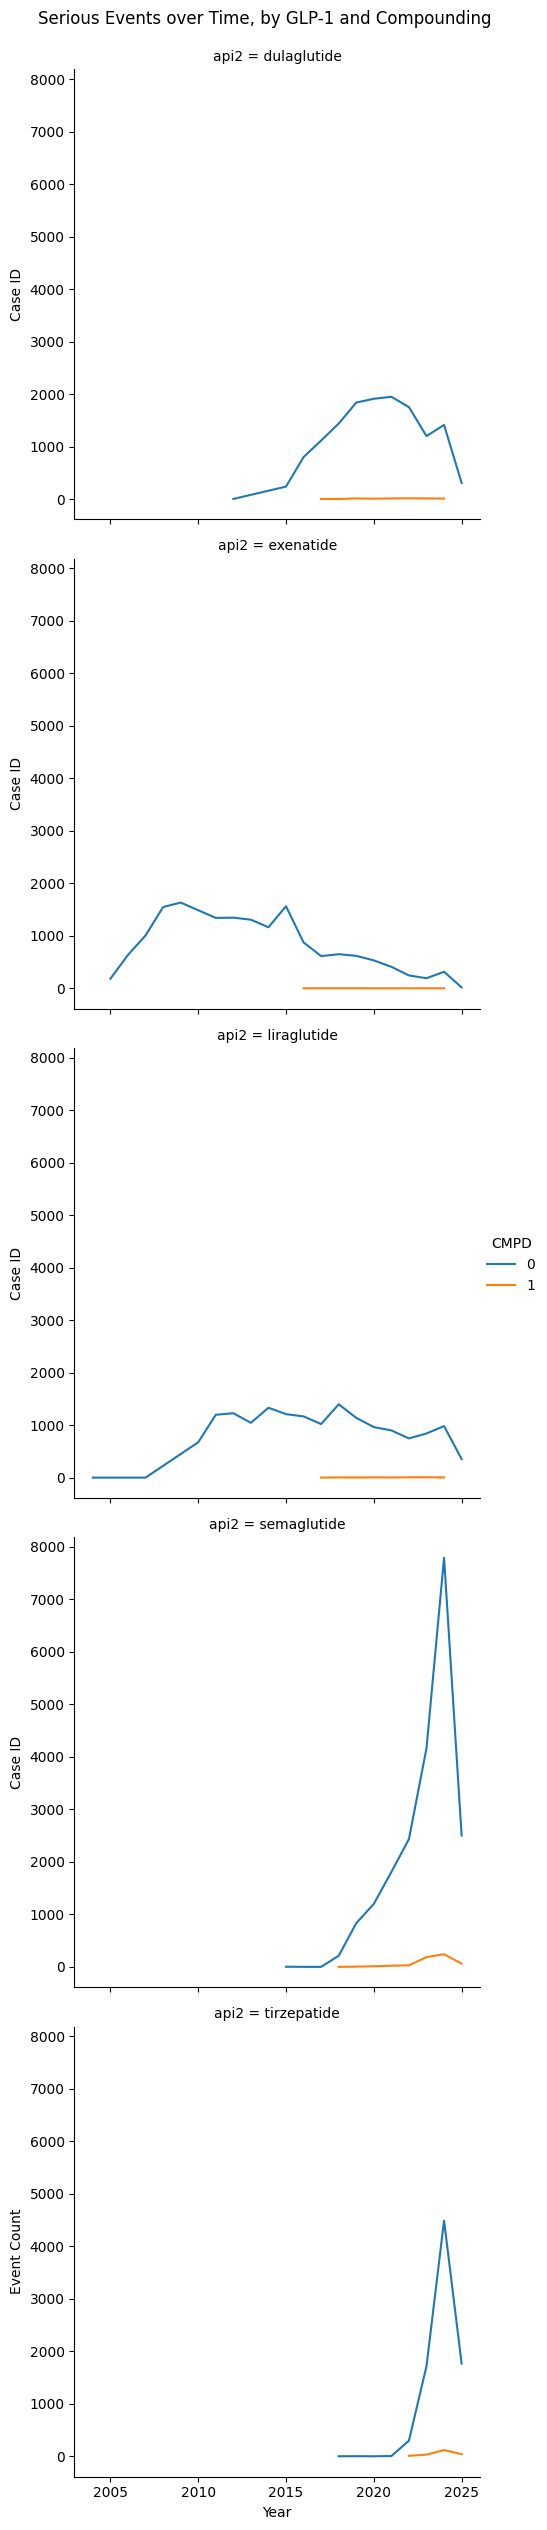

In [266]:
sns.relplot(x='Year1',y='Case ID',row='api2',data=glp1_time6,hue='CMPD',
            kind='line')
plt.suptitle('Serious Events over Time, by GLP-1 and Compounding',y=1.01)
plt.xlabel('Year')
plt.ylabel('Event Count')
plt.show()

Again, we see a rapid increase in serious events almost completely attributable to semaglutide and tirzepatide that is seen in both compounded and non-compounded versions.

### Event Counts

In [267]:
# 3 pandas series: Serious Rxns groupings
glp1_s_sum1 = glp1_s.groupby(['Sex'],as_index=False)['Case ID'].count()
glp1_s_sum2 = glp1_s.groupby(['api1'],as_index=False)['Case ID'].count()
glp1_s_sum3 = glp1_s.groupby(['CMPD'],as_index=False)['Case ID'].count()
glp1_s_sum4 = glp1_s.groupby(['Sex','api1','CMPD'])['Case ID'].count()
glp1_s_sum5 = glp1_s.groupby(['Sex','api1'])['Case ID'].count()
print('Serious Reactions Only:')
print('\tGroup by sex:\n',glp1_s_sum1,'\n----------------------\n')
print('\tGroup by drug:\n',glp1_s_sum2,'\n----------------------\n')
print('\tGroup by compounded:\n',glp1_s_sum3,'\n----------------------\n')
print('\tGroup by sex+drug+compounded:\n',glp1_s_sum4)
print('\tGroup by sex+drug:\n',glp1_s_sum5)
print('1=dulaglutide (2014), 2=exenatide (2005), 3=liraglutide (2010), 4=semaglutide (2017), 5=tirzepatide (2022)')

Serious Reactions Only:
	Group by sex:
              Sex  Case ID
0         Female    43060
1           Male    29430
2  Not Specified     5528 
----------------------

	Group by drug:
    api1  Case ID
0     1    14026
1     2    17716
2     3    16245
3     4    21548
4     5     8483 
----------------------

	Group by compounded:
    CMPD  Case ID
0     0    77117
1     1      901 
----------------------

	Group by sex+drug+compounded:
 Sex            api1  CMPD
Female         1     0        6628
                     1          48
               2     0        9541
                     1          10
               3     0        8953
                     1          30
               4     0       12334
                     1         453
               5     0        4887
                     1         176
Male           1     0        6005
                     1          20
               2     0        7441
                     1           5
               3     0        6191
     

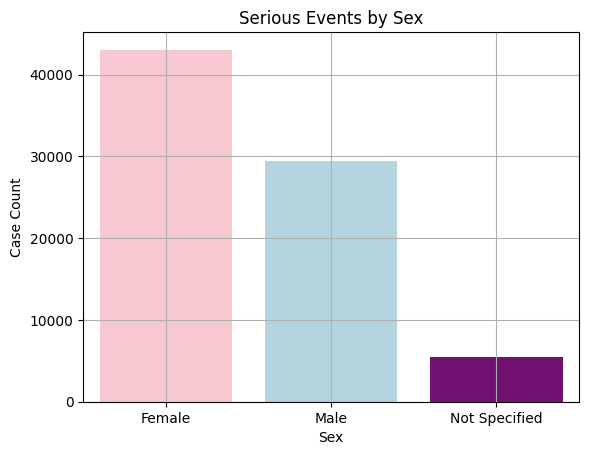

In [268]:
#serious events, by sex
my_colors = ["#FF5733", "#33FF57", "#3357FF"]
sns.countplot(x='Sex',data=glp1_s,hue='Sex',
              order=['Female','Male','Not Specified'],
              palette=['pink','purple','lightblue'])
plt.grid()
plt.title('Serious Events by Sex')
plt.xlabel('Sex')
plt.ylabel('Case Count')
plt.show()

Mostly Female at over 55%

Female cases outnumber Male, with significant unknown

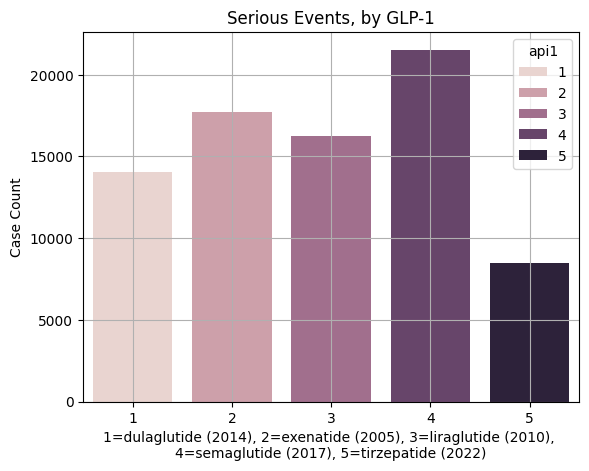

In [269]:
#Serious Events, by Drug
sns.countplot(x='api1',data=glp1_s,hue='api1')
plt.grid()
plt.xlabel('1=dulaglutide (2014), 2=exenatide (2005), 3=liraglutide (2010), \n4=semaglutide (2017), 5=tirzepatide (2022)')
plt.title('Serious Events, by GLP-1')
plt.ylabel('Case Count')
plt.show()

We can see that there are reported cases with all GLP-1s.

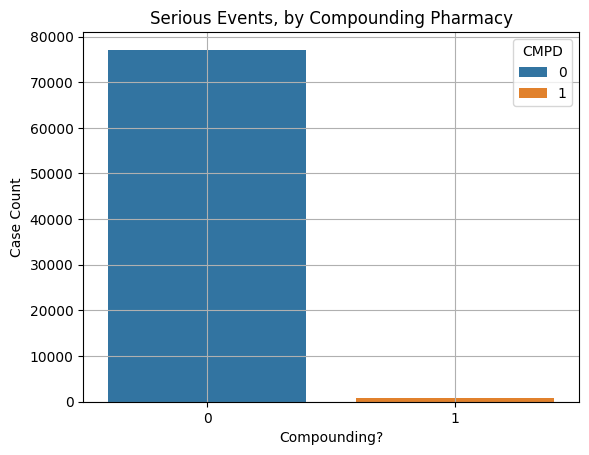

In [270]:
#Serious Events, by Compounding
#sns.countplot(glp1_s_sum3['CMPD'],glp1_s_sum3['Case ID'],
#        edgecolor='black',color=['blue','orange'])
sns.countplot(x='CMPD',data=glp1_s,hue='CMPD')
plt.grid()
plt.title('Serious Events, by Compounding Pharmacy')
plt.xlabel('Compounding?')
plt.ylabel('Case Count')
plt.show()

We see that compounded GLP1s make up a very small proportion of reported serious cases, at 1.2%.

In [271]:
#pandas series, by sex
print(glp1_s_sum1)

             Sex  Case ID
0         Female    43060
1           Male    29430
2  Not Specified     5528


Of all serious events, many more were reported by females (43k) than males (29k). There was a substantial number of cases without sex data (5.5k)

In [272]:
#pandas series, by drug
print(glp1_s_sum2)
print('1=dulaglutide (2014), 2=exenatide (2005), 3=liraglutide (2010), 4=semaglutide (2017), 5=tirzepatide (2022)')

   api1  Case ID
0     1    14026
1     2    17716
2     3    16245
3     4    21548
4     5     8483
1=dulaglutide (2014), 2=exenatide (2005), 3=liraglutide (2010), 4=semaglutide (2017), 5=tirzepatide (2022)


Of all serious events, most were related to semaglutide (21.5k), least was tirzepatide (8.5k). This is most likely driven by prescribing patterns and reflecting marketshare of various GLP1s.

In [273]:
#pandas series, by compounded
print(glp1_s_sum3)
a=glp1_s_sum3['Case ID'][1]
b=glp1_s_sum3['Case ID'][0]
c=round((a/(a+b))*100,2)
print('a:',a,'b:',b,'c:',c)
print(c,'% of serious events were compounded')

   CMPD  Case ID
0     0    77117
1     1      901
a: 901 b: 77117 c: 1.15
1.15 % of serious events were compounded


1.2% of serious events were from compounded GLP1s

In [274]:
#pandas series, by sex+drugs
print(glp1_s_sum5)

Sex            api1
Female         1        6676
               2        9551
               3        8983
               4       12787
               5        5063
Male           1        6025
               2        7446
               3        6200
               4        7564
               5        2195
Not Specified  1        1325
               2         719
               3        1062
               4        1197
               5        1225
Name: Case ID, dtype: int64


When broken down by sex and drug, the above pattern continue to hold: Females outnumber males in reports for every drug, though the difference is most pronounced for semaglutide, at 7.6k for males and 12.8k for females (almost double). Unsure why this is. Perhaps it is due to semaglutide's unique availability in oral dosage form.

In [275]:
#pandas series, by sex+drug+cpds
print(glp1_s_sum4)

Sex            api1  CMPD
Female         1     0        6628
                     1          48
               2     0        9541
                     1          10
               3     0        8953
                     1          30
               4     0       12334
                     1         453
               5     0        4887
                     1         176
Male           1     0        6005
                     1          20
               2     0        7441
                     1           5
               3     0        6191
                     1           9
               4     0        7454
                     1         110
               5     0        2170
                     1          25
Not Specified  1     0        1323
                     1           2
               2     0         719
               3     0        1062
               4     0        1186
                     1          11
               5     0        1223
                     1       

When broken down by sex, drug, and compounded flag, we see that there are reported serious events coming from compounded glp1s from every drug.

##4: Age
* pull in only age in years
* change to numeric, force other errors to NA
* exclude NAs
* filter out only age from 1-150
* cleaned up dataset is "glp1a"  
**Use Age_Years Column, updated**

In [276]:
glp1['Patient Age']=glp1['Patient Age'].str.replace(' YR','')

In [277]:
glp1['Patient Age']=pd.to_numeric(glp1['Patient Age'],errors='coerce')

In [278]:
#analyze missing NAs, part3
#print(data.isnull().sum())
print('NAs per column (focus on age)\n',glp1.isnull().sum())
print('----------\n','Shape of Dataset: \n',glp1.shape)

NAs per column (focus on age)
 Case ID                                    0
Suspect Product Names                      0
Suspect Product Active Ingredients         0
Reason for Use                             0
Reactions                                  0
Serious                                    0
Outcomes                                   0
Sex                                        0
Event Date                                 0
Latest FDA Received Date                   0
Case Priority                              0
Patient Age                           145158
Patient Weight                             0
Sender                                     0
Reporter Type                              0
Report Source                              0
Concomitant Product Names                  0
Latest Manufacturer Received Date          0
Initial FDA Received Date                  0
Country where Event occurred               0
Reported to Manufacturer?                  0
Manufacturer Control Num

New cleaned age column has 135k NA compared to 145K from before, thanks!

In [279]:
glp1b=glp1.dropna(subset=['Age_Years']) #valid age only
glp1a=glp1b[(glp1b['Age_Years'] >0) & (glp1b['Age_Years'] < 150)].copy() #realistic age values only (1-150)
glp1a['Age_Years']

,Age_Years
0,80.0
1,80.0
2,85.0
3,71.0
4,63.0
...,...
300549,55.0
300550,32.0
300551,49.0
300552,74.0


In [280]:
#checking descriptive statistics on glp1a['Age_years']
glp1a['Age_Years'].describe()

,Age_Years
count,166029.000000
mean,58.439152
std,12.880129
min,0.002740
25%,50.000000
50%,60.000000
75%,68.000000
max,121.000000


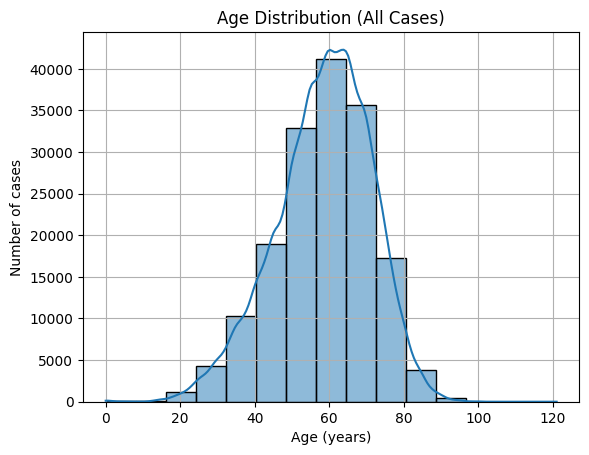

In [281]:
#histogram 1 (age distribution, all cases)
#quick check on distribution of age
sns.histplot(glp1a['Age_Years'],bins=15,kde=True)
plt.grid()
plt.title('Age Distribution (All Cases)')
plt.xlabel("Age (years)")
plt.ylabel("Number of cases")
plt.show()

This shows that age for all cases is a normally distributed continuous variable. There does not appear to be any skewness; symmetric normal distribution. Visually, the mean is around 60 (actual is 58).

In [282]:
print('NAs per column (focus on age)\n',glp1.isnull().sum())
print('----------\n','Shape of Dataset: \n',glp1.shape)

NAs per column (focus on age)
 Case ID                                    0
Suspect Product Names                      0
Suspect Product Active Ingredients         0
Reason for Use                             0
Reactions                                  0
Serious                                    0
Outcomes                                   0
Sex                                        0
Event Date                                 0
Latest FDA Received Date                   0
Case Priority                              0
Patient Age                           145158
Patient Weight                             0
Sender                                     0
Reporter Type                              0
Report Source                              0
Concomitant Product Names                  0
Latest Manufacturer Received Date          0
Initial FDA Received Date                  0
Country where Event occurred               0
Reported to Manufacturer?                  0
Manufacturer Control Num

###: Filtering and Selecting Data
* Filter out serious vs non-serious events (rows)
* Select only relevant variables (columns)

In [283]:
#filter out serious events and relevant columns
var=['Case ID','Serious','Outcomes','Sex','Age_Years','Patient Weight','CMPD','api1']
glp1a_s=glp1a.query("Serious == 'Serious'")[var] #valid age, serious events
glp1a_ns=glp1a.query("Serious == 'Non-Serious'")[var] #valid age, non-serious events


In [284]:
print('Serious Events, Valid Age\n',glp1a_s)

Serious Events, Valid Age
          Case ID  Serious                                Outcomes  \
3       25140677  Serious                            Hospitalized   
7       25139513  Serious             Other Outcomes;Hospitalized   
17      25138176  Serious                          Other Outcomes   
20      25140295  Serious      Required Intervention;Hospitalized   
21      25137010  Serious                          Other Outcomes   
...          ...      ...                                     ...   
300548  24910845  Serious                          Other Outcomes   
300549  24904201  Serious                            Hospitalized   
300550  24642147  Serious  Life Threatening;Required Intervention   
300551  24398076  Serious                            Hospitalized   
300553  24129001  Serious                   Disabled;Hospitalized   

                  Sex  Age_Years Patient Weight  CMPD  api1  
3              Female       71.0  Not Specified     0     1  
7              Femal

In [285]:
print('Non-Serious Events, valid age\n',glp1a_ns)

Non-Serious Events, valid age
          Case ID      Serious     Outcomes     Sex  Age_Years Patient Weight  \
0       25142581  Non-Serious  Non-Serious    Male       80.0  Not Specified   
1       25142580  Non-Serious  Non-Serious  Female       80.0  Not Specified   
2       25141349  Non-Serious  Non-Serious    Male       85.0  Not Specified   
4       25140673  Non-Serious  Non-Serious  Female       63.0  Not Specified   
5       25140096  Non-Serious  Non-Serious  Female       42.0  Not Specified   
...          ...          ...          ...     ...        ...            ...   
300530  21060519  Non-Serious  Non-Serious  Female       55.0  Not Specified   
300540  21043000  Non-Serious  Non-Serious  Female       28.0  Not Specified   
300543  21035667  Non-Serious  Non-Serious  Female       40.0  Not Specified   
300547  25085870  Non-Serious  Non-Serious    Male       50.0        94.5 KG   
300552  24327525  Non-Serious  Non-Serious  Female       74.0        86.4 KG   

        

query is a useful shortcut!

### Groupby for Scientific Insights
* Focus on Serious Events only
* Group by: a) sex,
b) drug;
c) sex&drug
* lamda fxn for quartiles

In [286]:
#serious events, grouped by sex
glp1a_s_sum1 = glp1a_s.groupby(['Sex'])['Age_Years'].agg(['mean','median','min','max','size',
 ('q25',lambda x: x.quantile(0.25)),('q75',lambda x: x.quantile(0.75)) ])
print('\n \tAge of Serious Events, by Sex: \n',glp1a_s_sum1)

glp1a_s_sum2 = glp1a_s.groupby(['api1'])['Age_Years'].agg(['mean','median','min','max','size',
     ('q25',lambda x: x.quantile(0.25)),('q75',lambda x: x.quantile(0.75)) ])
print('\n \tAge of Serious Events, by drug: \n',glp1a_s_sum2)

glp1a_s_sum3 = glp1a_s.groupby(['Sex','api1'])['Age_Years'].agg(['mean','median','min','max','size',
     ('q25',lambda x: x.quantile(0.25)),('q75',lambda x: x.quantile(0.75)) ])
print('\n \tAge of Serious Events, by sex and drug: \n',glp1a_s_sum3)

print('1=dulaglutide (2014), 2=exenatide (2005), 3=liraglutide (2010), 4=semaglutide (2017), 5=tirzepatide (2022)')



 	Age of Serious Events, by Sex: 
                     mean  median       min    max   size   q25   q75
Sex                                                                 
Female         57.229779    59.0  0.071233  104.0  28234  48.0  67.0
Male           60.770536    62.0  0.002740  100.0  19827  53.0  70.0
Not Specified  57.858334    59.0  0.008219  100.0    954  49.0  68.0

 	Age of Serious Events, by drug: 
            mean  median       min    max   size   q25   q75
api1                                                       
1     62.174575    63.0  0.500000  100.0   7403  54.0  72.0
2     60.359273    61.0  0.002740  100.0  11860  53.0  68.0
3     57.931726    60.0  0.002740  104.0  11023  50.0  67.0
4     57.899674    60.0  0.076923  100.0  13797  48.0  69.0
5     53.194911    54.0  0.008219  100.0   4932  42.0  64.0

 	Age of Serious Events, by sex and drug: 
                          mean     median        min         max  size   q25  \
Sex           api1                    

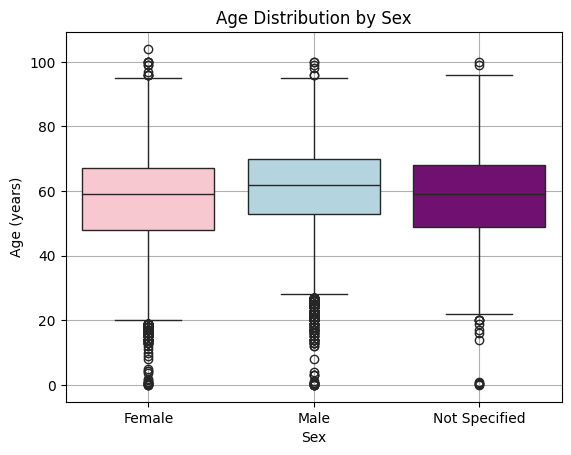

In [287]:
sns.boxplot(x='Sex',y='Age_Years',data=glp1a_s,hue='Sex',
            order=['Female','Male','Not Specified'],palette=['pink','purple','lightblue'])
plt.grid()
plt.title('Age Distribution by Sex')
plt.xlabel("Sex")
plt.ylabel("Age (years)")
plt.show()

Male age tends to be a bit older than females.

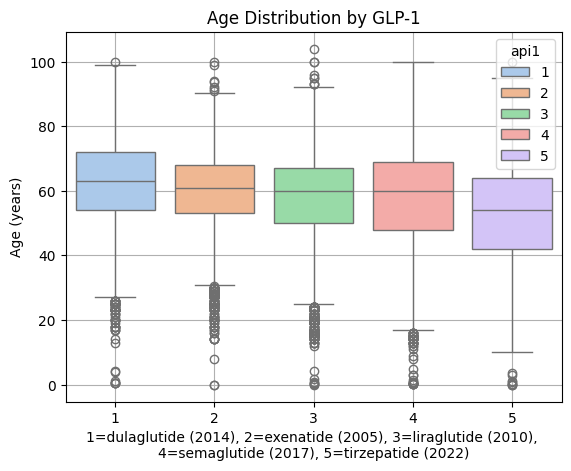

In [288]:
sns.boxplot(x='api1',y='Age_Years',data=glp1a_s,hue='api1',palette='pastel')
plt.grid()
plt.title('Age Distribution by GLP-1')
plt.xlabel('1=dulaglutide (2014), 2=exenatide (2005), 3=liraglutide (2010), \n4=semaglutide (2017), 5=tirzepatide (2022)')
plt.ylabel("Age (years)")
plt.show()

It looks like tirzepatide serious events may be a bit younger than most.

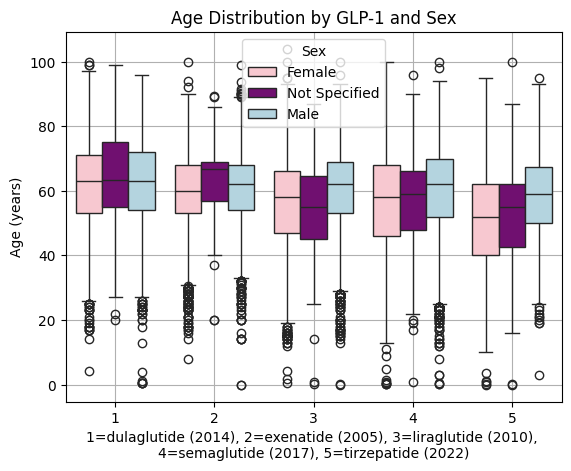

In [289]:
sns.boxplot(x='api1',y='Age_Years',data=glp1a_s,hue='Sex',palette=['pink','purple','lightblue'])
plt.grid()
plt.title('Age Distribution by GLP-1 and Sex')
plt.xlabel('1=dulaglutide (2014), 2=exenatide (2005), 3=liraglutide (2010), \n4=semaglutide (2017), 5=tirzepatide (2022)')
plt.ylabel("Age (years)")
plt.show()

The age difference between M/F is most pronounced with tirzepatide

##Pivot Tables

In [290]:
#drug x sex
print('Serious Reactions, drug x sex')
print(glp1a_s.pivot_table(index='api1',columns='Sex',values='Age_Years',aggfunc=['mean','median']))
print('1=dulaglutide (2014), 2=exenatide (2005), 3=liraglutide (2010), 4=semaglutide (2017), 5=tirzepatide (2022)')

Serious Reactions, drug x sex
           mean                          median                    
Sex      Female       Male Not Specified Female  Male Not Specified
api1                                                               
1     61.718110  62.541844     63.841880   63.0  63.0     63.500000
2     59.864249  60.942829     63.357785   60.0  62.0     66.787671
3     56.275876  60.285085     53.627702   58.0  62.0     55.000000
4     56.292161  60.606768     55.835003   58.0  62.0     59.000000
5     51.065107  58.043208     52.755837   52.0  59.0     55.000000
1=dulaglutide (2014), 2=exenatide (2005), 3=liraglutide (2010), 4=semaglutide (2017), 5=tirzepatide (2022)


In [291]:
glp1a_s.columns

Index(['Case ID', 'Serious', 'Outcomes', 'Sex', 'Age_Years', 'Patient Weight',
       'CMPD', 'api1'],
      dtype='object')

In [292]:
#drug x compounded
print('Serious Reactions, drug x compounded')
print(glp1a_s.pivot_table(index='api1',columns='CMPD',values='Age_Years',aggfunc=['mean','median']))
print('Compounded, CMPD (0=no, 1=yes)')
print('1=dulaglutide (2014), 2=exenatide (2005), 3=liraglutide (2010), 4=semaglutide (2017), 5=tirzepatide (2022)')

Serious Reactions, drug x compounded
           mean            median      
CMPD          0          1      0     1
api1                                   
1     62.212354  57.974747   63.0  58.0
2     60.357165  62.142857   61.0  62.0
3     57.960954  49.482456   60.0  47.5
4     58.206582  50.521628   60.0  51.0
5     53.370186  48.959687   55.0  48.0
Compounded, CMPD (0=no, 1=yes)
1=dulaglutide (2014), 2=exenatide (2005), 3=liraglutide (2010), 4=semaglutide (2017), 5=tirzepatide (2022)


compounded age appears to trend consistently lower than non-compounded, for all drugs

In [293]:
glp1a_s.groupby('CMPD')['Age_Years'].describe()

,count,mean,std,min,25%,50%,75%,max
CMPD,,,,,,,,
0,48150.0,58.814323,13.648466,0.00274,50.0,60.0,68.833333,104.0
1,865.0,50.878824,14.255891,0.09863,41.0,52.0,61.000000,89.0


In [294]:
#apologies I couldn't help myself, I wonder if the age diff is statistically sig
from scipy import stats
sample1=glp1a_s[glp1a_s['CMPD']==0]['Age_Years'] #non-compounded
sample2=glp1a_s[glp1a_s['CMPD']==1]['Age_Years'] #compounded
print('sample1, non-compounded',sample1)
sample1.describe()
print('sample2, compounded',sample2)

sample1, non-compounded 3         71.0
7         44.0
17        66.0
20        74.0
21        83.0
          ... 
300371    46.0
300444    50.0
300445    29.0
300522    61.0
300537    44.0
Name: Age_Years, Length: 48150, dtype: float64
sample2, compounded 1687      66.0
2394      34.0
2823      48.0
3303      61.0
3827      66.0
          ... 
300548    73.0
300549    55.0
300550    32.0
300551    49.0
300553    32.0
Name: Age_Years, Length: 865, dtype: float64


In [295]:
t_statistic, p_value=stats.ttest_ind(sample1,sample2)
print('t-statistic: ',t_statistic)
print('p-value: ',p_value)

t-statistic:  16.9349574563199
p-value:  3.785736685468843e-64


It's statistically significant??!! Did I do that right? Let's check histogram

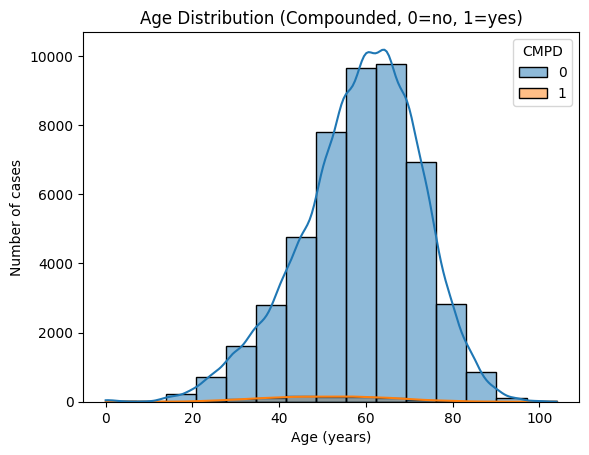

In [296]:
#histogram 2 (age distribution, serious cases)
sns.histplot(x='Age_Years',data=glp1a_s,bins=15,kde=True,hue='CMPD',fill=True)
plt.title('Age Distribution (Compounded, 0=no, 1=yes)')
plt.xlabel("Age (years)")
plt.ylabel("Number of cases")
plt.show()

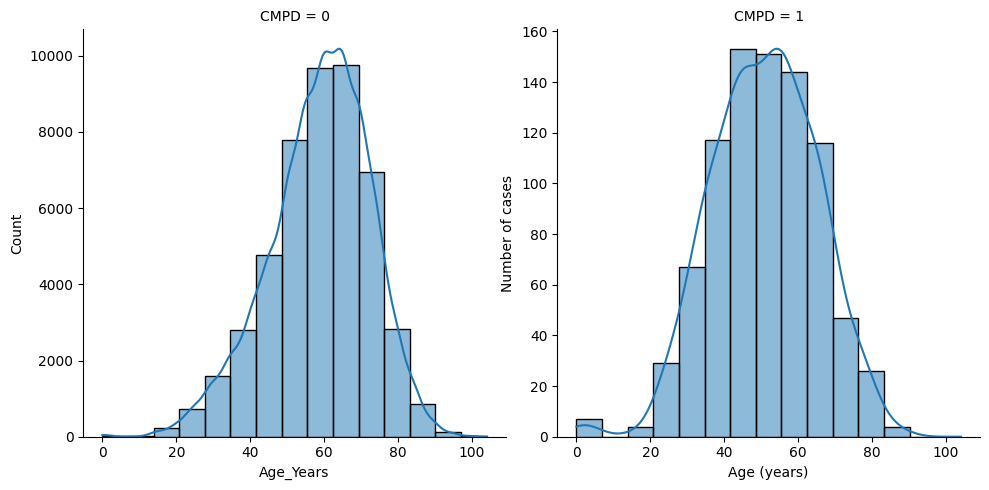

In [297]:
sns.displot(x='Age_Years',data=glp1a_s,bins=15,kde=True,col='CMPD',facet_kws={'sharey': False})
plt.xlabel("Age (years)")
plt.ylabel("Number of cases")
plt.show()

From both histograms, the age distribution when split by compounding, remain mostly symmetric normal with no skew. There appears to be strange outliers at both tails, probably data quality issues to be adjudicated.

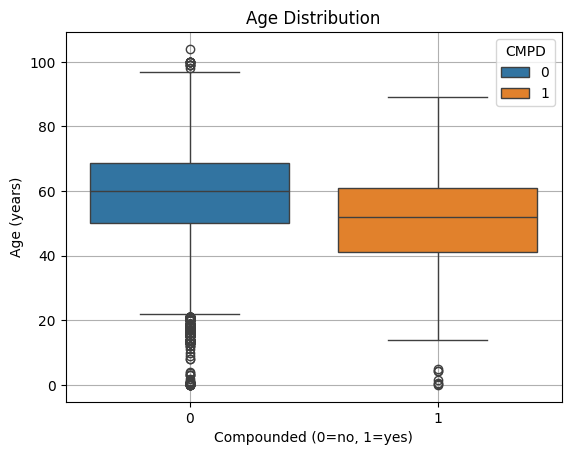

In [298]:
sns.boxplot(x='CMPD',y='Age_Years',data=glp1a_s,hue='CMPD')
plt.grid()
plt.title('Age Distribution')
plt.xlabel("Compounded (0=no, 1=yes)")
plt.ylabel("Age (years)")
plt.show()

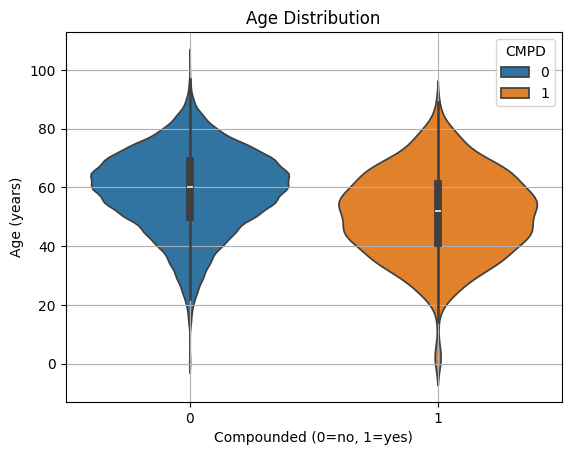

In [299]:
sns.violinplot(x='CMPD',y='Age_Years',data=glp1a_s,hue='CMPD')
plt.grid()
plt.title('Age Distribution')
plt.xlabel("Compounded (0=no, 1=yes)")
plt.ylabel("Age (years)")
plt.show()

So I think the two samples are statistically significant per the two-indept t-test. Unfortunately I don't know if this is a valid test to use as I'm not sure if all the assumptions are met, in addition to the two samples having very different sample size. My personal opinion on this is that this difference is probably real, as people on the compounded versions of GLP1s may be younger and taking it for...cosmetic...reasons. (and risking SAE events along with it)

In [300]:
#drug x
print('Serious Reactions, drug x compounded and sex')
print(glp1a_s.pivot_table(index='api1',columns=('CMPD','Sex'),values='Age_Years',aggfunc=['mean','median']))
print('Compounded, CMPD (0=no, 1=yes)')
print('1=dulaglutide (2014), 2=exenatide (2005), 3=liraglutide (2010), 4=semaglutide (2017), 5=tirzepatide (2022)')

Serious Reactions, drug x compounded and sex
           mean                                                               \
CMPD          0                                   1                            
Sex      Female       Male Not Specified     Female       Male Not Specified   
api1                                                                           
1     61.785632  62.553136     63.759657  56.398551  60.473684          83.0   
2     59.867068  60.933895     63.357785  57.777778  70.000000           NaN   
3     56.321901  60.286292     53.627702  46.321839  59.666667           NaN   
4     56.691618  60.700161     55.896461  49.150948  56.141509          52.0   
5     51.229215  58.080142     52.851299  48.076600  55.833333          35.0   

     median                                                 
CMPD      0                          1                      
Sex  Female  Male Not Specified Female  Male Not Specified  
api1                                               

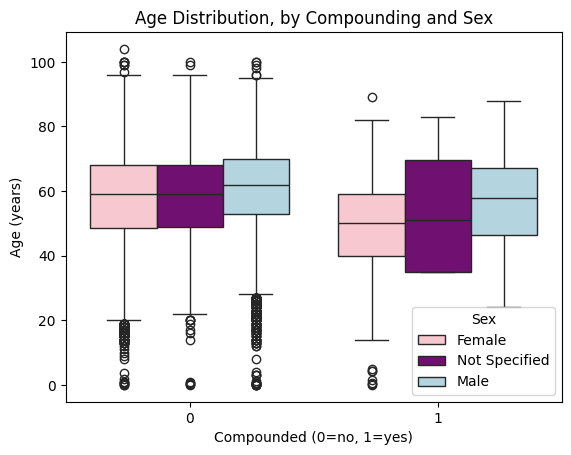

In [301]:
sns.boxplot(x='CMPD',y='Age_Years',data=glp1a_s,hue='Sex',palette=['pink','purple','lightblue'])
plt.title('Age Distribution, by Compounding and Sex')
plt.xlabel("Compounded (0=no, 1=yes)")
plt.ylabel("Age (years)")
plt.show()

The younger age of compounded GLP-1s may be mostly attributable to females, as the male age remains similar.

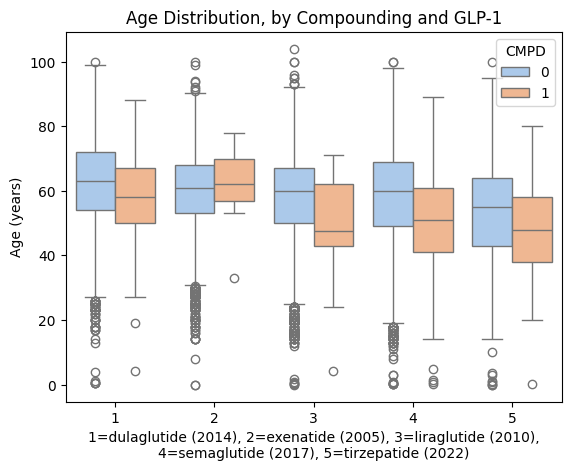

In [302]:
sns.boxplot(x='api1',y='Age_Years',data=glp1a_s,hue='CMPD',palette='pastel')
plt.title('Age Distribution, by Compounding and GLP-1')
plt.xlabel('1=dulaglutide (2014), 2=exenatide (2005), 3=liraglutide (2010),\n4=semaglutide (2017), 5=tirzepatide (2022)')
plt.ylabel("Age (years)")
plt.show()

Compounded GLP-1 serious event age is consistently younger across all GLP-1s, except for exenatide.

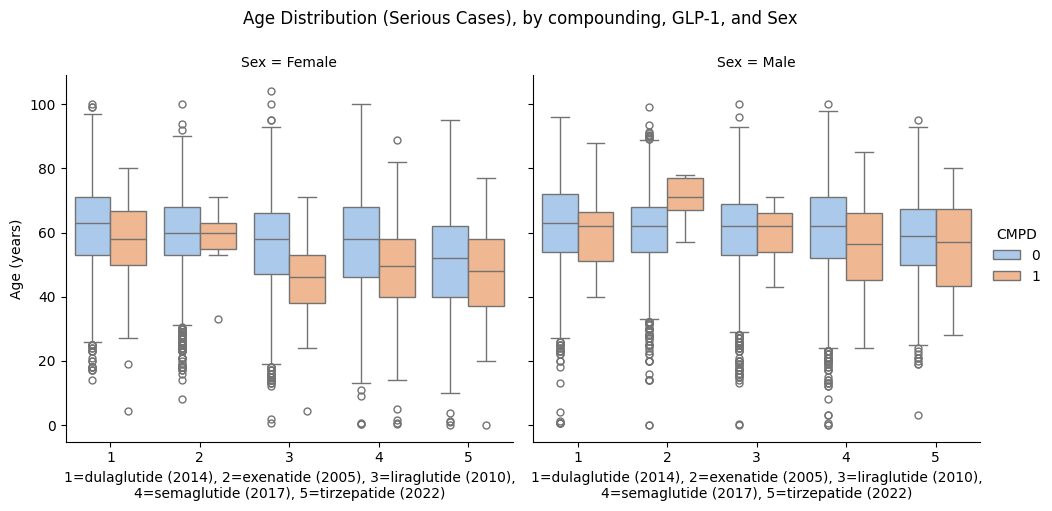

In [303]:
pltf1=sns.catplot(x='api1',y='Age_Years',col='Sex',data=glp1a_s[glp1a_s['Sex']!='Not Specified'],hue='CMPD',palette='pastel',kind='box')
pltf1.set_axis_labels('1=dulaglutide (2014), 2=exenatide (2005), 3=liraglutide (2010),\n4=semaglutide (2017), 5=tirzepatide (2022)','Age (years)')
plt.subplots_adjust(top=0.85)  # Move down to fit suptitle
plt.suptitle('Age Distribution (Serious Cases), by compounding, GLP-1, and Sex')
plt.show()

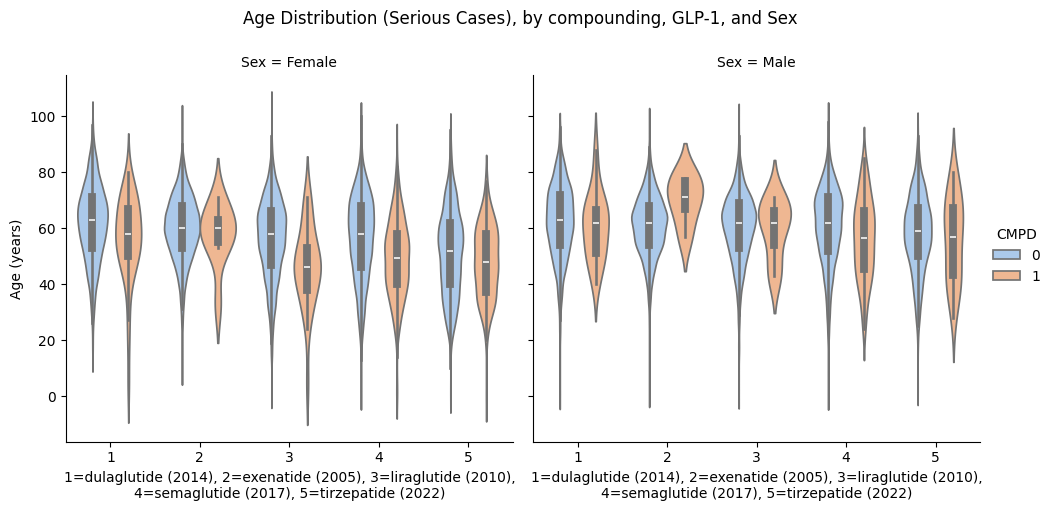

In [304]:
pltf1=sns.catplot(x='api1',y='Age_Years',col='Sex',data=glp1a_s[glp1a_s['Sex']!='Not Specified'],hue='CMPD',palette='pastel',kind='violin')
pltf1.set_axis_labels('1=dulaglutide (2014), 2=exenatide (2005), 3=liraglutide (2010),\n4=semaglutide (2017), 5=tirzepatide (2022)','Age (years)')
plt.subplots_adjust(top=0.85)  # Move down to fit suptitle
plt.suptitle('Age Distribution (Serious Cases), by compounding, GLP-1, and Sex')
plt.show()

The trend of serious events from compounded GLP-1 trending younger than non-compounded holds for both M and F, and is seen across most GLP-1s, except for liraglutide, where this pattern is not seen in males. Note the very young ages of serious events from young females on liraglutide, semaglutide, and tirzepatide.

## Testing/scratch Area

Caveats:
* No rate information can be inferred without total Rx dispensed
* Correlation is not causation

Disclaimer:
Please note that this was developed for academic coursework, and is intended for educational purposes ONLY. The information provided does NOT imply causation, safety, or efficacy. This is not medical advice and should not be used to diagnose, treat, cure, or prevent any disease. Always consult a qualified healthcare professional for any health-related concerns. No guarantees are made regarding the completeness, accuracy, or timeliness of the information provided. Full disclaimer: (https://www.fda.gov/drugs/fdas-adverse-event-reporting-system-faers/fda-adverse-event-reporting-system-faers-public-dashboard)